In [1]:
import numpy as np
import xsimlab as xs

In [2]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [3]:
def createMultiComp(base_process, comp_label, comp_dim):
    
    @xs.process
    class AddIndexCompLabel(base_process):
        label = xs.variable(intent='out')
        dim = xs.variable(intent='out')
        index = xs.index(dims=comp_label)
        
        output = xs.variable(intent='out', dims=(comp_label,'time'))
        
        def initialize(self):
            self.label = comp_label
            self.dim = comp_dim
            self.index = [f"{comp_label}-{i}" for i in range(comp_dim)]
            super(AddIndexCompLabel,self).initialize()
           
    return AddIndexCompLabel

In [4]:
print('xarray-simlab version: ', xs.__version__)
print('phydra version: ', phydra.__version__)

xarray-simlab version:  0.4.1
phydra version:  0+untagged.51.gb1dd1f2.dirty


In [5]:
model = xs.Model({'time':phydra.processes.main.Time, 'grid':phydra.processes.main.Grid0D, 
                  'ibcs':phydra.processes.main.Boundary0D, 'context':phydra.processes.main.GekkoContext, 
                  'C1':createMultiComp(phydra.processes.main.Component,'c1',5), 'C2':createMultiComp(phydra.processes.main.Component,'c2',5),
                  'flux':phydra.processes.main.Flux, 'solver':phydra.processes.main.GekkoSolve})

model

<xsimlab.Model (8 processes, 9 inputs)>
time
    days           [in] ('time',) time in days
grid
    shape          [in]
    length         [in]
ibcs
    ibc            [in] Initial Boundary Conditions
context
C1
    init           [in]
C2
    init           [in]
flux
    growthrate     [in]
    c1_label       [in]
    c2_label       [in]
solver

In [6]:
model.index_vars 

[('time', 'time'), ('C1', 'index'), ('C2', 'index')]

In [7]:
def phydra_setup(model, input_vars, output_vars):
    return xs.create_setup(model=model, 
                           # necessary for xsimlab
                           clocks={'clock': [0, 1]},
                           input_vars=input_vars,
                           output_vars=output_vars)

in_ds = phydra_setup(
    model=model,
    input_vars={
        'time__days': ('time', np.arange(0, 15)),
        'C1':{'init':1}, 
        'C2':{'init':2}, #the way dims are handled need to be specified in each flux!
        
        'flux':{'growthrate':0.1,
                'c1_label':'c1',
                'c2_label':'c2'}
    },
    output_vars={
        'C1__output':None , 
        'C2__output':None 
    }
                 )

In [8]:
with model:
    out_ds = in_ds.xsimlab.run()

Initializing Model Time
Initializing Gekko Context
Initializing component  c1
Initializing component  c2
Initializing Flux
Assembling equation for component  c1
Assembling equation for component  c2
SolveInit
Model context dict stores: dict_items([('shape', [1]), ('components', [('c1', 5), ('c2', 5)])])
ModelSolve done
Storing output component  c1
Storing output component  c2


In [9]:
out_ds

<xarray.Dataset>
Dimensions:           (c1: 5, c2: 5, clock: 2, time: 15)
Coordinates:
  * clock             (clock) int64 0 1
  * time              (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
Dimensions without coordinates: c1, c2
Data variables:
    C1__init          int64 1
    C1__output        (c1, time) float64 1.0 1.111 1.235 ... 3.541 3.934 4.371
    C2__init          int64 2
    C2__output        (c2, time) float64 2.0 2.222 2.469 ... 7.081 7.868 8.742
    flux__c1_label    <U2 'c1'
    flux__c2_label    <U2 'c2'
    flux__growthrate  float64 0.1
    grid__length      int64 1
    grid__shape       int64 1
    ibcs__ibc         float64 nan
    index             (c1) <U4 'c2-0' 'c2-1' 'c2-2' 'c2-3' 'c2-4'
    time__days        (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14

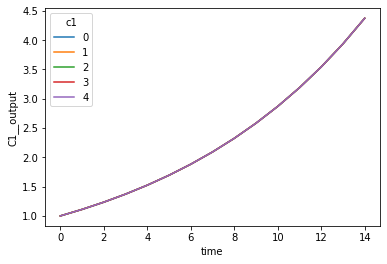

In [10]:
out_ds.C1__output.set_index(time='time').plot.line(x='time')

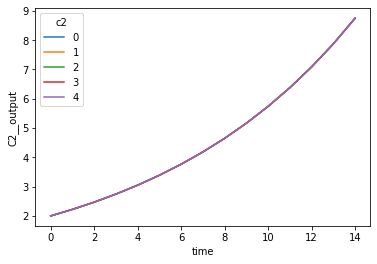

In [11]:
out_ds.C2__output.set_index(time='time').plot.line(x='time')